# Train new U-Net model

In [ ]:
import os
!git clone https://github.com/yumouwei/camvid_unet_semantic_segmentation.git
os.chdir("camvid_unet_semantic_segmentation" )
print(f"Changed directory to: {os.getcwd()}")


Cloning into 'camvid_unet_semantic_segmentation'...
remote: Enumerating objects: 2980, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 2980 (delta 63), reused 35 (delta 5), pack-reused 2842 (from 1)
Receiving objects: 100% (2980/2980), 647.03 MiB | 44.26 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Updating files: 100% (2841/2841), done.
Changed directory to: /content/camvid_unet_semantic_segmentation


## 1. Load data to memory

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from utils import load_data_from_dir, convert_indexed_to_rgb_mask, convert_indexed_to_rgb_masks

In [ ]:
base_dir = os.getcwd()

train_image_df = pd.read_csv(base_dir + '/data/camvid_train.txt', header=None, sep=' ', names=['image', 'mask'])
val_image_df = pd.read_csv(base_dir + '/data/camvid_val.txt', header=None, sep=' ', names=['image', 'mask'])
test_image_df = pd.read_csv(base_dir + '/data/camvid_test.txt', header=None, sep=' ', names=['image', 'mask'])

classes = [
    'Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree',
    'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist',
    'Void'
    ]

n_class = 11  # ignore 'Void' (background) class

In [ ]:
%%time
image_dim = (224, 224)  # same as vgg-16
train_images, train_masks = load_data_from_dir(train_image_df, True, image_dim)
val_images, val_masks = load_data_from_dir(val_image_df, True, image_dim)
test_images, test_masks = load_data_from_dir(test_image_df, True, image_dim)

367it [00:10, 33.80it/s]
101it [00:02, 36.98it/s]
233it [00:06, 35.77it/s]


CPU times: user 19 s, sys: 1.28 s, total: 20.3 s
Wall time: 20.4 s


In [ ]:
print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)
print(test_images.shape)
print(test_masks.shape)

(367, 224, 224, 3)
(367, 224, 224, 1)
(101, 224, 224, 3)
(101, 224, 224, 1)
(233, 224, 224, 3)
(233, 224, 224, 1)


Displaying Training Examples:


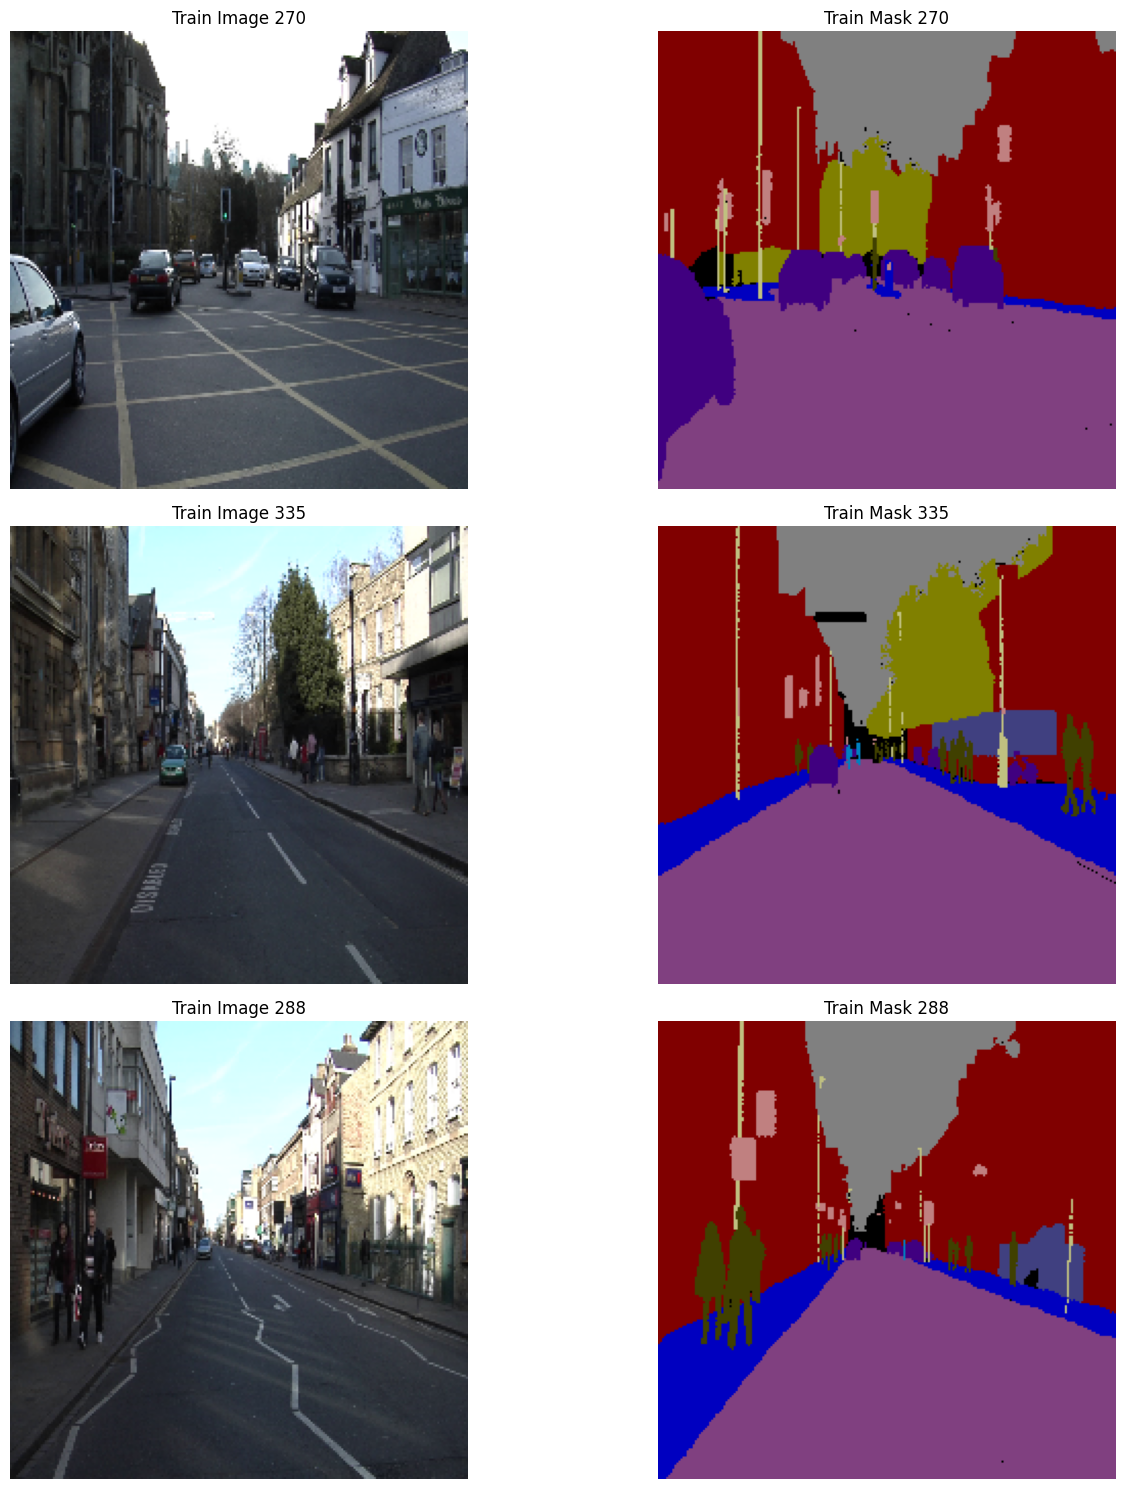


Displaying Validation Examples:


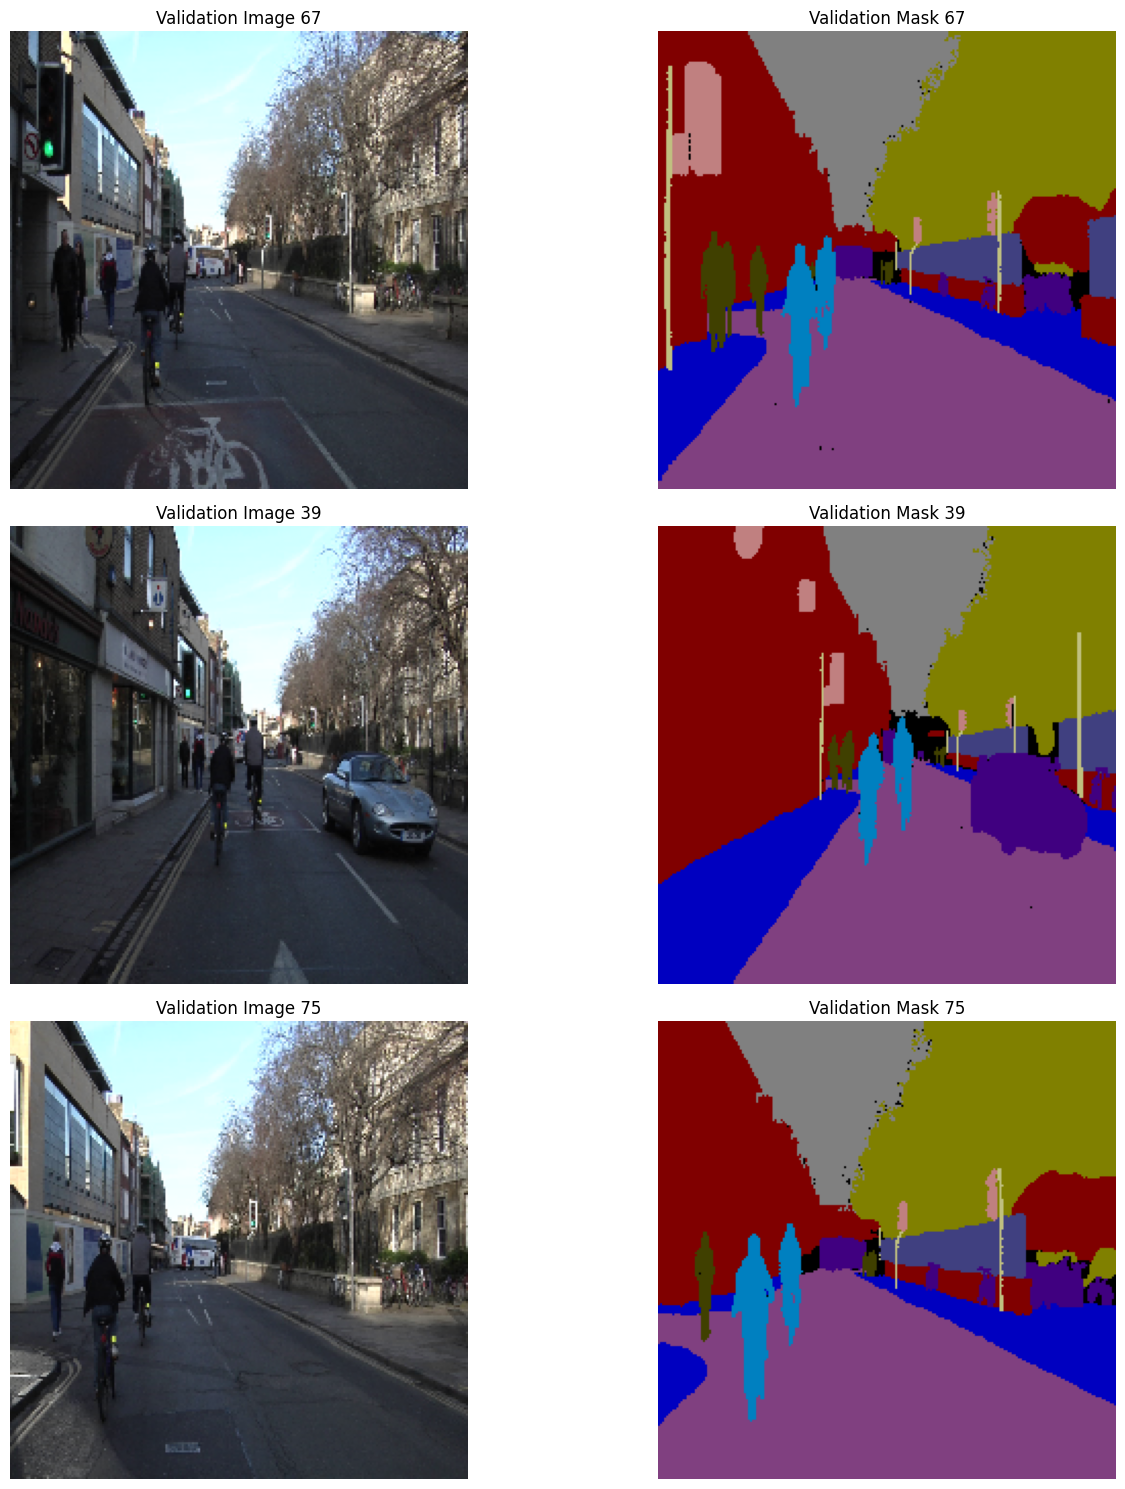


Displaying Test Examples:


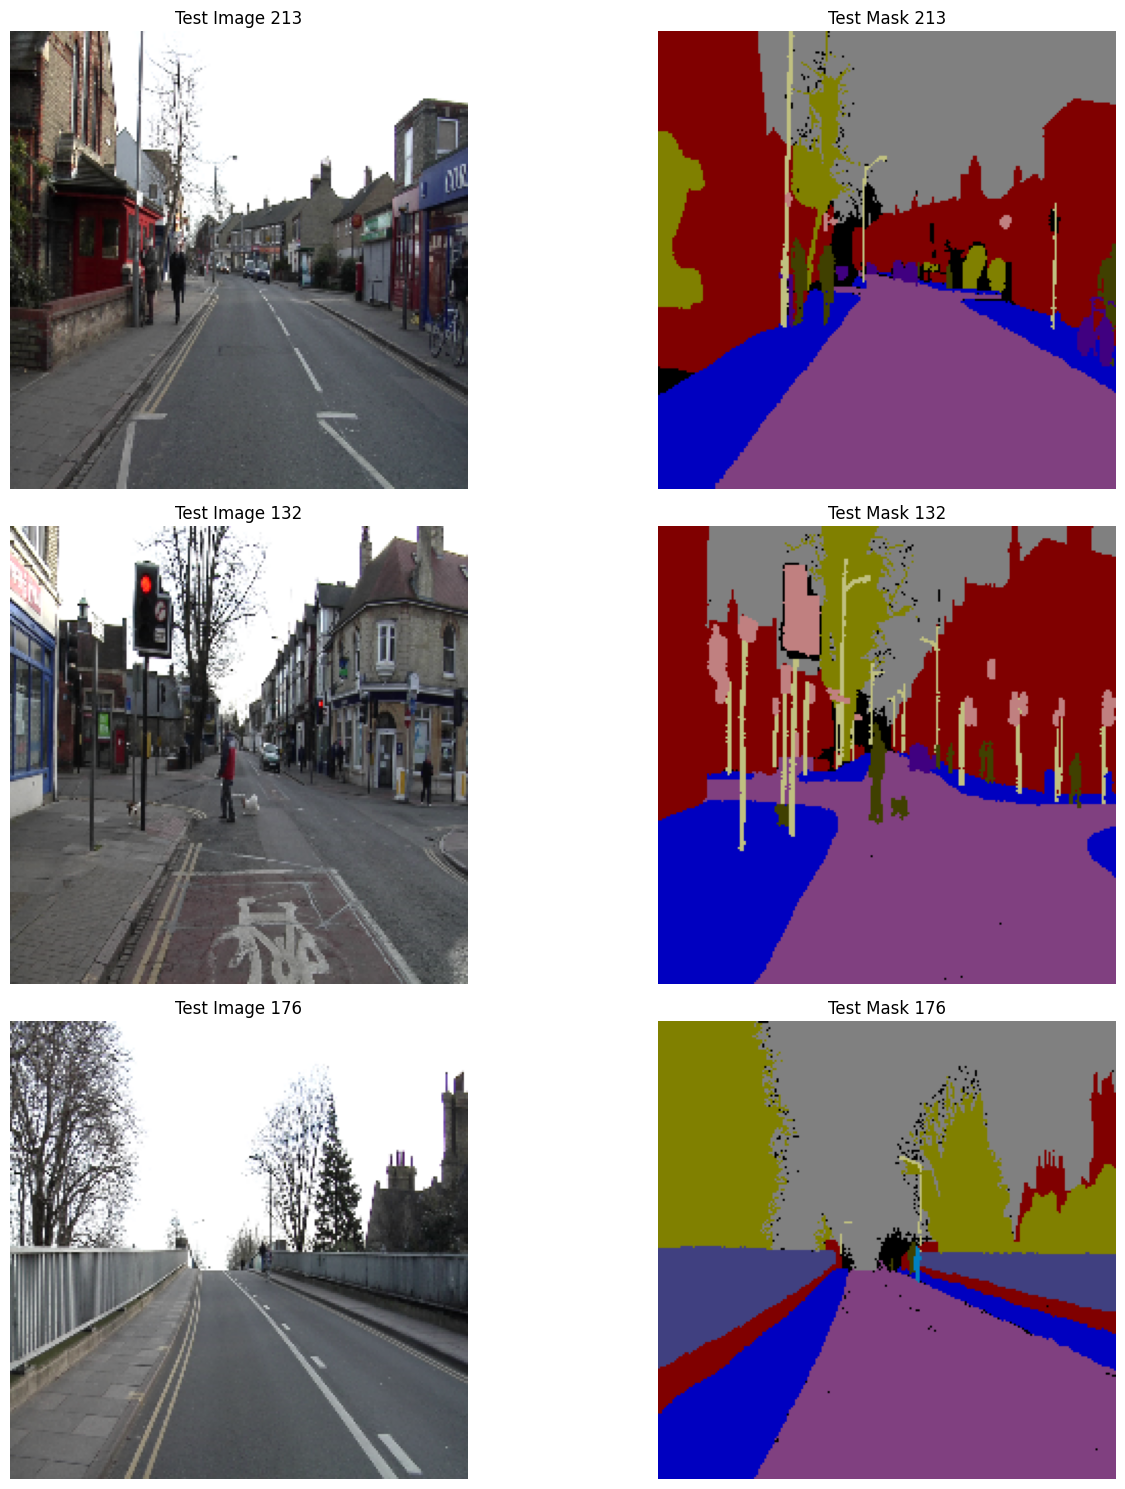

In [ ]:
def display_examples(images, masks, dataset_name, num_examples=3):
    plt.figure(figsize=(15, 5 * num_examples))
    indices = np.random.choice(len(images), num_examples, replace=False)

    for i, idx in enumerate(indices):
        # Original Image
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(images[idx])
        plt.title(f'{dataset_name} Image {idx}')
        plt.axis('off')

        # Mask (converted to RGB)
        rgb_mask = convert_indexed_to_rgb_mask(masks[idx])
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(rgb_mask)
        plt.title(f'{dataset_name} Mask {idx}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


print("Displaying Training Examples:")
display_examples(train_images, train_masks, "Train")

print("\nDisplaying Validation Examples:")
display_examples(val_images, val_masks, "Validation")

print("\nDisplaying Test Examples:")
display_examples(test_images, test_masks, "Test")

## 2. Build U-Net model

### 2.1 Use vanilla U-Net architecture

In [ ]:
from build_model import build_unet

unet_model = build_unet(input_shape = train_images.shape[1:],
                        num_classes = 11,
                        num_filters = 64,
                        kernel_size = 3)

unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,827,275 (121.41 MB)

 Trainable params: 31,814,987 (121.36 MB)

 Non-trainable params: 12,288 (48.00 KB)

In [ ]:
# Set loss and compile model

tf.keras.backend.clear_session()

# Use SCCE loss to save memory
SCCE = tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=255) # ignore void class in loss calculation

unet_model.compile(optimizer="adam", loss=SCCE, metrics=['accuracy'])

In [ ]:
# Plot network architecture

from tensorflow.keras.utils import plot_model
plot_model(unet_model, show_shapes=True, show_layer_names=True)

## 3. Train model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

train_val = True   # Use train & valid sets to optimize hyperparameters
train_test = False  # Use all train and valid set data to train a final model and then evaluate on the test set

epochs = 100

if train_val:

    earlystopping = EarlyStopping(monitor="val_loss", patience = 20, restore_best_weights=True)
    callbacks_list = [earlystopping]

    history = unet_model.fit(train_images, train_masks, epochs=epochs, callbacks = callbacks_list,
                             validation_data=(val_images, val_masks), verbose=2)

    unet_model.evaluate(train_images, train_masks)
    unet_model.evaluate(val_images, val_masks)

elif train_test:

    history = unet_model.fit(np.concatenate((train_images, val_images), axis=0),
                             np.concatenate((train_masks, val_masks), axis=0),
                             epochs=epochs,
                             verbose=2)

    unet_model.evaluate(train_images, train_masks)
    unet_model.evaluate(test_images, test_masks)

Epoch 1/100
12/12 - 265s - 22s/step - accuracy: 0.5706 - loss: 1.3538 - val_accuracy: 0.1151 - val_loss: 3.8624
Epoch 2/100
12/12 - 22s - 2s/step - accuracy: 0.7397 - loss: 0.7684 - val_accuracy: 0.2864 - val_loss: 11.1487
Epoch 3/100
12/12 - 21s - 2s/step - accuracy: 0.7846 - loss: 0.6165 - val_accuracy: 0.2865 - val_loss: 10.8344
Epoch 4/100
12/12 - 20s - 2s/step - accuracy: 0.8093 - loss: 0.5377 - val_accuracy: 0.2865 - val_loss: 9.8080
Epoch 5/100
12/12 - 21s - 2s/step - accuracy: 0.8185 - loss: 0.5077 - val_accuracy: 0.2865 - val_loss: 5.3200
Epoch 6/100
12/12 - 21s - 2s/step - accuracy: 0.8318 - loss: 0.4585 - val_accuracy: 0.2865 - val_loss: 5.4234
Epoch 7/100
12/12 - 21s - 2s/step - accuracy: 0.8363 - loss: 0.4408 - val_accuracy: 0.3433 - val_loss: 4.7213
Epoch 8/100
12/12 - 21s - 2s/step - accuracy: 0.8429 - loss: 0.4137 - val_accuracy: 0.2865 - val_loss: 5.3566
Epoch 9/100
12/12 - 21s - 2s/step - accuracy: 0.8501 - loss: 0.3910 - val_accuracy: 0.3034 - val_loss: 5.0263
Epoch 

### Plot history

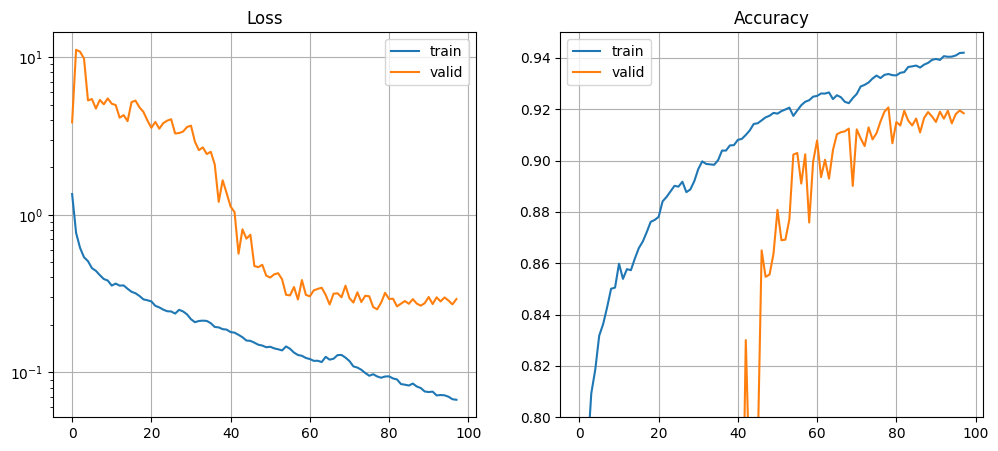

In [ ]:
if train_val:
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='valid')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid()
    ax[0].set_yscale("log")

    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].plot(history.history['val_accuracy'], label='valid')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_ylim(0.8, 0.95)
    plt.show()

elif train_test:
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].plot(history.history['loss'], label='train')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid()
    ax[0].set_yscale("log")


    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_ylim(0.8, 0.98)
    plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

train_val = False   # Use train & valid sets to optimize hyperparameters
train_test = True  # Use all train and valid set data to train a final model and then evaluate on the test set

epochs = 100

if train_val:

    earlystopping = EarlyStopping(monitor="val_loss", patience = 20, restore_best_weights=True)
    callbacks_list = [earlystopping]

    history = unet_model.fit(train_images, train_masks, epochs=epochs, callbacks = callbacks_list,
                             validation_data=(val_images, val_masks), verbose=2)

    unet_model.evaluate(train_images, train_masks)
    unet_model.evaluate(val_images, val_masks)

elif train_test:

    history = unet_model.fit(np.concatenate((train_images, val_images), axis=0),
                             np.concatenate((train_masks, val_masks), axis=0),
                             epochs=epochs,
                             verbose=2)

    unet_model.evaluate(train_images, train_masks)
    unet_model.evaluate(test_images, test_masks)

Epoch 1/100
15/15 - 25s - 2s/step - accuracy: 0.9351 - loss: 0.1042
Epoch 2/100
15/15 - 25s - 2s/step - accuracy: 0.9361 - loss: 0.1013
Epoch 3/100
15/15 - 23s - 2s/step - accuracy: 0.9370 - loss: 0.0979
Epoch 4/100
15/15 - 24s - 2s/step - accuracy: 0.9355 - loss: 0.1023
Epoch 5/100
15/15 - 25s - 2s/step - accuracy: 0.9360 - loss: 0.1012
Epoch 6/100
15/15 - 24s - 2s/step - accuracy: 0.9364 - loss: 0.0998
Epoch 7/100
15/15 - 24s - 2s/step - accuracy: 0.9373 - loss: 0.0972
Epoch 8/100
15/15 - 24s - 2s/step - accuracy: 0.9371 - loss: 0.0973
Epoch 9/100
15/15 - 24s - 2s/step - accuracy: 0.9383 - loss: 0.0937
Epoch 10/100
15/15 - 24s - 2s/step - accuracy: 0.9395 - loss: 0.0899
Epoch 11/100
15/15 - 24s - 2s/step - accuracy: 0.9399 - loss: 0.0888
Epoch 12/100
15/15 - 24s - 2s/step - accuracy: 0.9406 - loss: 0.0865
Epoch 13/100
15/15 - 24s - 2s/step - accuracy: 0.9416 - loss: 0.0837
Epoch 14/100
15/15 - 24s - 2s/step - accuracy: 0.9424 - loss: 0.0812
Epoch 15/100
15/15 - 24s - 2s/step - accura

### Plot history

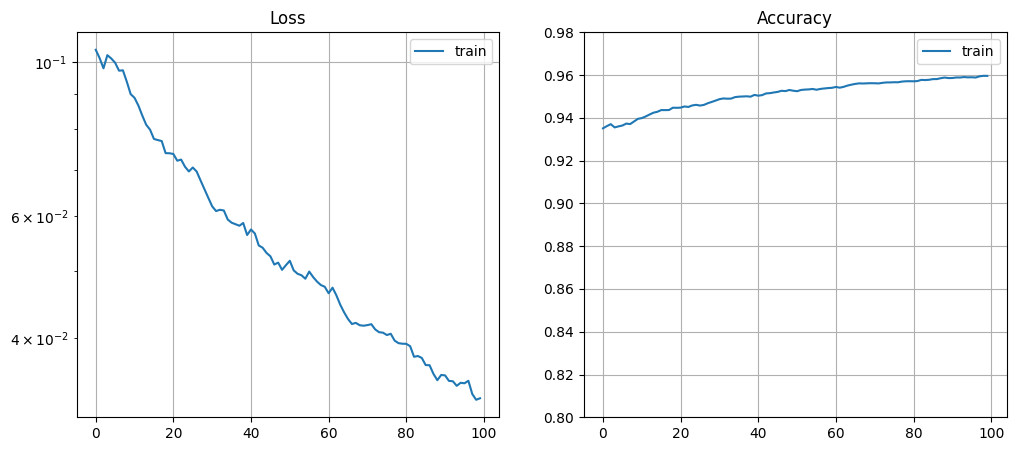

In [ ]:
if train_val:
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='valid')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid()
    ax[0].set_yscale("log")

    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].plot(history.history['val_accuracy'], label='valid')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_ylim(0.8, 0.95)
    plt.show()

elif train_test:
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].plot(history.history['loss'], label='train')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid()
    ax[0].set_yscale("log")


    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_ylim(0.8, 0.98)
    plt.show()

In [ ]:
# Save model
save_model = True
model_name = 'new_unet_model.h5'

if save_model:
    unet_model.save(os.path.join(base_dir, 'models', model_name))

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')
shutil.copy("/content/camvid_unet_semantic_segmentation/models/new_unet_model.h5", "/content/drive/MyDrive/undet-seg-driving-videos.h5")

Mounted at /content/drive


'/content/drive/MyDrive/undet-seg-driving-videos.h5'

In [ ]:
# Load sequences of test data as individual sets -- useful for evaluating model performance in different light conditions
# Load Seq05VD -- 171 frames
test_df_Seq05VD = test_image_df.loc[test_image_df['image'].str.contains("Seq05VD")]
test_images_Seq05VD, test_masks_Seq05VD = load_data_from_dir(test_df_Seq05VD, True, image_dim)

# Load 0001TP_2 -- 62 frames
test_df_0001TP = test_image_df.loc[test_image_df['image'].str.contains("0001TP")]
test_images_0001TP, test_masks_0001TP = load_data_from_dir(test_df_0001TP, True, image_dim)

171it [00:05, 32.76it/s]
62it [00:01, 39.43it/s]


In [ ]:
masks = test_masks
# masks = test_masks_Seq05VD
# masks = test_masks_0001TP

unique, counts = np.unique(masks, return_counts=True)
total = sum(counts)

dict(zip(classes, (counts/total).round(3)))

{'Sky': np.float64(0.173),
 'Building': np.float64(0.247),
 'Pole': np.float64(0.012),
 'Road': np.float64(0.253),
 'Pavement': np.float64(0.095),
 'Tree': np.float64(0.113),
 'SignSymbol': np.float64(0.01),
 'Fence': np.float64(0.012),
 'Car': np.float64(0.042),
 'Pedestrian': np.float64(0.007),
 'Bicyclist': np.float64(0.002),
 'Void': np.float64(0.035)}

In [ ]:
# masks = test_masks
masks = test_masks_Seq05VD
# masks = test_masks_0001TP

unique, counts = np.unique(masks, return_counts=True)
total = sum(counts)

dict(zip(classes, (counts/total).round(3)))

{'Sky': np.float64(0.157),
 'Building': np.float64(0.281),
 'Pole': np.float64(0.013),
 'Road': np.float64(0.289),
 'Pavement': np.float64(0.11),
 'Tree': np.float64(0.077),
 'SignSymbol': np.float64(0.012),
 'Fence': np.float64(0.013),
 'Car': np.float64(0.017),
 'Pedestrian': np.float64(0.005),
 'Bicyclist': np.float64(0.001),
 'Void': np.float64(0.024)}

In [ ]:
# masks = test_masks
# masks = test_masks_Seq05VD
masks = test_masks_0001TP

unique, counts = np.unique(masks, return_counts=True)
total = sum(counts)

dict(zip(classes, (counts/total).round(3)))

{'Sky': np.float64(0.216),
 'Building': np.float64(0.153),
 'Pole': np.float64(0.007),
 'Road': np.float64(0.154),
 'Pavement': np.float64(0.054),
 'Tree': np.float64(0.212),
 'SignSymbol': np.float64(0.005),
 'Fence': np.float64(0.008),
 'Car': np.float64(0.111),
 'Pedestrian': np.float64(0.012),
 'Bicyclist': np.float64(0.005),
 'Void': np.float64(0.065)}

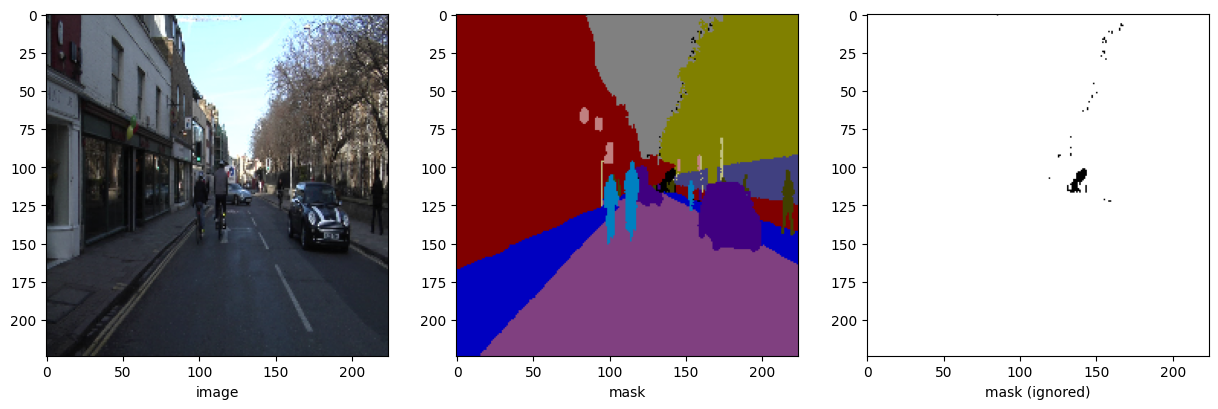

In [ ]:
from utils import convert_indexed_to_rgb_mask

i = 0

fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].imshow(val_images[i], vmin=0, vmax=1)
ax[0].set_xlabel('image')
ax[1].imshow(convert_indexed_to_rgb_mask(val_masks[i]))
ax[1].set_xlabel('mask')
ax[2].imshow(val_masks[i] == 255, cmap='binary')
ax[2].set_xlabel('mask (ignored)')
plt.show()

In [ ]:
images = test_images
masks = test_masks
# images = test_images_Seq05VD
# masks = test_masks_Seq05VD
# images = test_images_0001TP
# masks = test_masks_0001TP

In [ ]:
unet_model.evaluate(images, masks)

masks_pred = unet_model.predict(images)
masks_pred = np.expand_dims(np.argmax(masks_pred, axis=-1), -1)

# Assign values in void regions to 255
masks_pred[masks == 255] = 255

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.8161 - loss: 0.8503
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


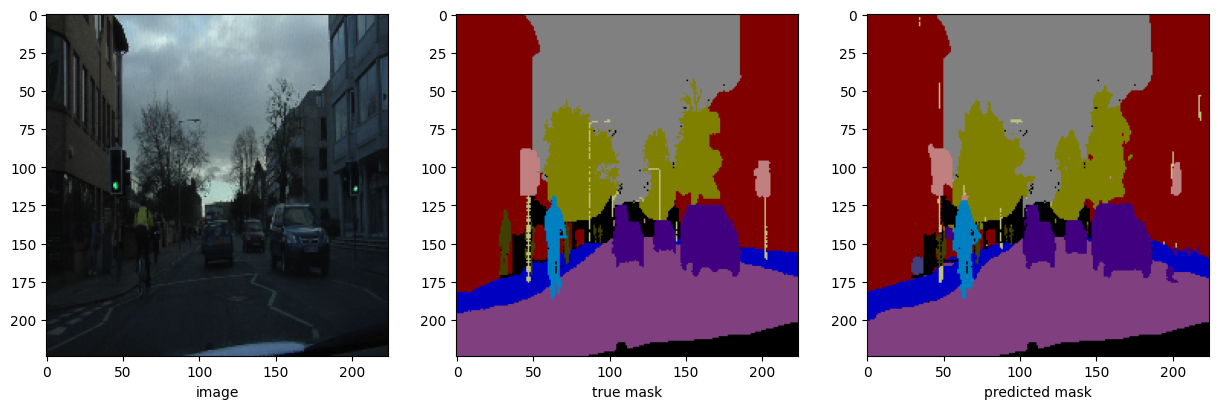

In [ ]:
i = 0

fig, ax = plt.subplots(1,3, figsize=(15,6), dpi=100)
ax[0].imshow(images[i], vmin=0, vmax=1)
ax[0].set_xlabel('image')
ax[1].imshow(convert_indexed_to_rgb_mask(masks[i]))
ax[1].set_xlabel('true mask')
ax[2].imshow(convert_indexed_to_rgb_mask(masks_pred[i]))
ax[2].set_xlabel('predicted mask')
plt.show()

In [ ]:
from utils import evaluate_pixel_accuracy_by_class, evaluate_pixel_accuracy_global

# Pixel accuracy by class
class_acc = np.zeros(n_class)
for i in range(n_class):
    class_acc[i] = evaluate_pixel_accuracy_by_class(masks, masks_pred, i_class=i)*100

# Global average
global_acc = evaluate_pixel_accuracy_global(masks, masks_pred)*100

print('Pixel-wise accuracy:')
for i in range(n_class):
    print(str(i) + '. ' + classes[i] + ': {:.1f}'.format(class_acc[i]))
print('Class avg: {:.1f}'.format(class_acc[:11].sum()/12))
print('Global avg: {:.1f}'.format(global_acc))

Pixel-wise accuracy:
0. Sky: 96.4
1. Building: 85.2
2. Pole: 26.7
3. Road: 96.9
4. Pavement: 84.7
5. Tree: 75.3
6. SignSymbol: 42.0
7. Fence: 13.6
8. Car: 78.0
9. Pedestrian: 40.9
10. Bicyclist: 32.3
Class avg: 56.0
Global avg: 86.3


In [ ]:
from utils import evaluate_jaccard_score_by_class

iou = np.zeros(n_class)
for i in range(n_class):
    iou[i] = evaluate_jaccard_score_by_class(masks, masks_pred, i_class=i)

print('Test set IOU by class:')
for i in range(n_class):
    print(classes[i] + ': ' + str(iou[i].round(2)))
print('11-category mIOU:' + str(iou[:11].mean().round(2)))

Test set IOU by class:
Sky: 0.9
Building: 0.73
Pole: 0.18
Road: 0.92
Pavement: 0.73
Tree: 0.64
SignSymbol: 0.3
Fence: 0.09
Car: 0.65
Pedestrian: 0.24
Bicyclist: 0.24
11-category mIOU:0.51


In [ ]:
from utils import convert_indexed_to_rgb_masks
import imageio
import cv2

masks_pred_rgb = convert_indexed_to_rgb_masks(masks_pred)
masks_rgb = convert_indexed_to_rgb_masks(masks)
images_uint8 = (images*255).astype('uint8')

imgs = np.concatenate([images_uint8,
                cv2.addWeighted(images_uint8, 0.5, masks_rgb, 0.5, 0),
                cv2.addWeighted(images_uint8, 0.5, masks_pred_rgb, 0.5, 0)], axis=2)

filename = 'animation.gif'
imageio.mimsave(filename, imgs, fps=7)

In [ ]:
from IPython.display import Image
Image(filename=filename)